/tmp/ipykernel_2160037/1728021542.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.87, 1])  # rect 값도 조정 (0.9 -> 0.87)


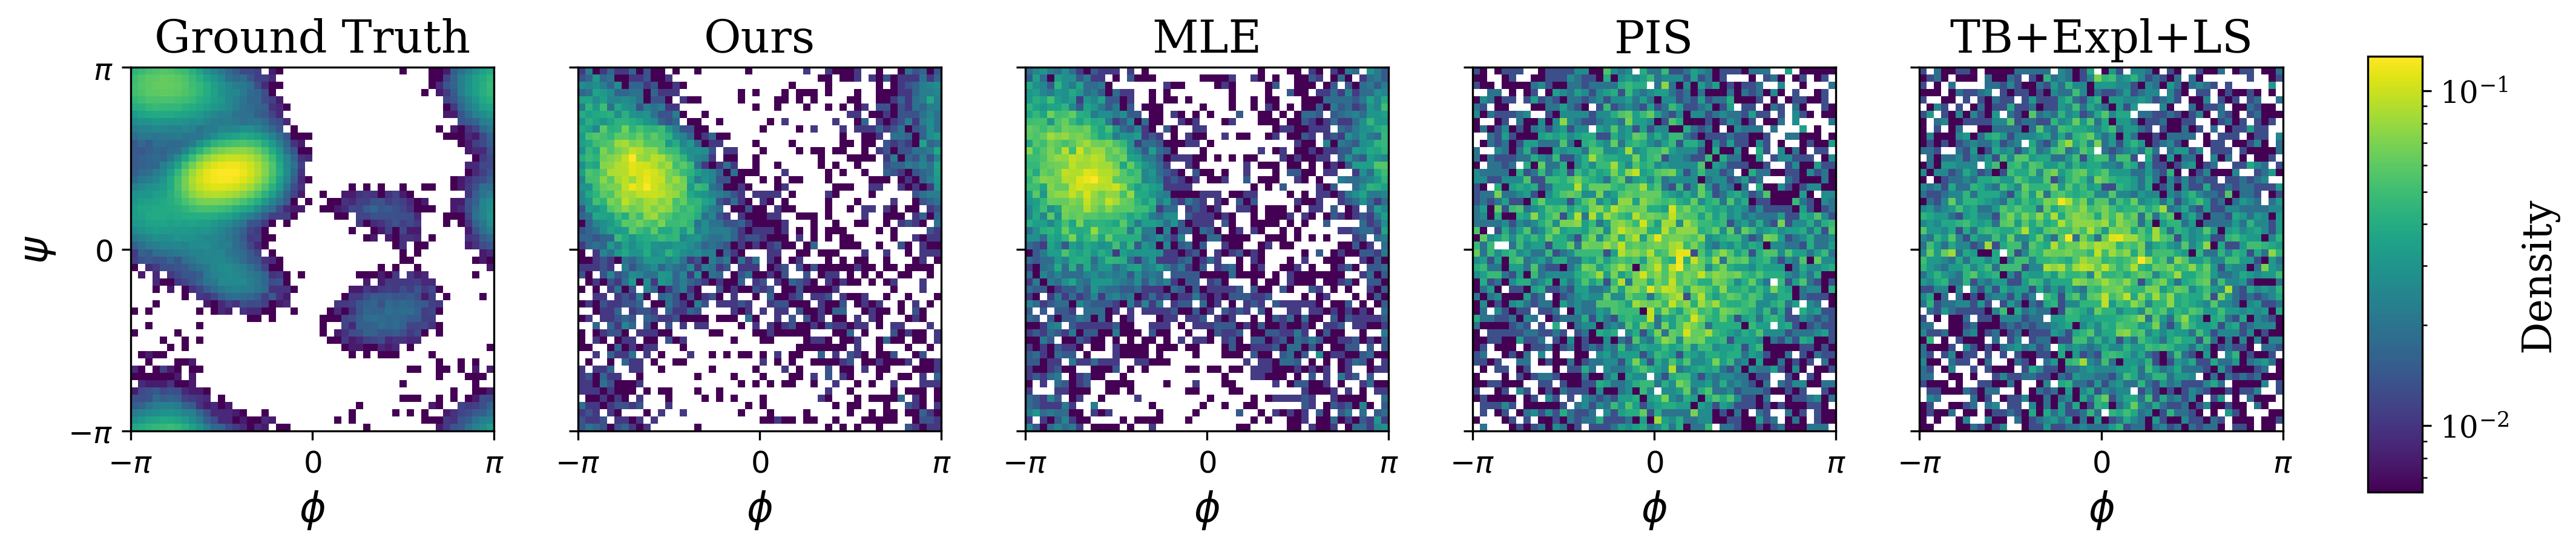

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterMathtext

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16,
    'axes.labelsize': 12,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'lines.linewidth': 1.5,
})

def compute_dihedral(xs):
    v = xs[:, :-1] - xs[:, 1:]
    v0 = -v[:, 0]
    v1 = v[:, 2]
    v2 = v[:, 1]

    s0 = np.sum(v0 * v2, axis=-1, keepdims=True) / np.sum(v2 * v2, axis=-1, keepdims=True)
    s1 = np.sum(v1 * v2, axis=-1, keepdims=True) / np.sum(v2 * v2, axis=-1, keepdims=True)

    v0 = v0 - s0 * v2
    v1 = v1 - s1 * v2

    v0 = v0 / np.linalg.norm(v0, axis=-1, keepdims=True)
    v1 = v1 / np.linalg.norm(v1, axis=-1, keepdims=True)
    v2 = v2 / np.linalg.norm(v2, axis=-1, keepdims=True)

    x = np.sum(v0 * v1, axis=-1)
    v3 = np.cross(v0, v2, axis=-1)
    y = np.sum(v3 * v1, axis=-1)
    return np.arctan2(y, x)

def plot_phi_psi_row(xs_dict):
    names = list(xs_dict.keys())
    n = len(names)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3), sharex=True, sharey=True)

    # colorbar용 빈 축(axis) 하나 추가 (맨 우측)
    cax = fig.add_axes([0.88, 0.1, 0.02, 0.8])  # 왼쪽으로 이동 (0.92 -> 0.88)

    # 히스토그램 bin 경계
    xedges = np.linspace(-np.pi, np.pi, 51)
    yedges = np.linspace(-np.pi, np.pi, 51)

    quadmesh = None
    for i, name in enumerate(names):
        ax = axes[i]
        xs = xs_dict[name]
        # index mapping은 기존과 동일
        psi = compute_dihedral(xs[:, [6,8,14,16], :])
        phi = compute_dihedral(xs[:, [1,6,8,14], :])

        # 히스토그램
        quadmesh = ax.hist2d(
            phi, psi,
            bins=[xedges, yedges],
            norm=LogNorm(),
            cmap="viridis",
            density=True
        )

        # 축 설정: 정사각형으로
        ax.set_aspect('equal')
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        ax.set_xticks([-np.pi, 0, np.pi])
        ax.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
        ax.set_yticks([-np.pi, 0, np.pi])
        ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])

        # 레이블: φ는 모든 subplot, ψ는 가장 왼쪽만
        ax.set_xlabel(r'$\phi$')
        if i == 0:
            ax.set_ylabel(r'$\psi$')
        else:
            ax.set_ylabel('')

        ax.set_title(name)

    # 공통 colorbar: 로그틱 눈금
    cb = fig.colorbar(
        quadmesh[3],      # hist2d의 QuadMesh 객체
        cax=cax,
        ticks=[1, 1e-1, 1e-2, 1e-3, 1e-4]  # 예시: 10^0, 10^-1, ..., 10^-4
    )
    cb.locator = LogLocator(base=10)                # 10배수 눈금만 표시
    cb.formatter = LogFormatterMathtext(base=10)     # 10^n 형태 레이블
    cb.update_ticks()                                # formatter 적용
    cb.set_label('Density')

    plt.tight_layout(rect=[0, 0, 0.87, 1])  # rect 값도 조정 (0.9 -> 0.87)
    plt.savefig('../figure/phi_psi.png', format='png', dpi=300, bbox_inches='tight')
    plt.savefig('../figure/phi_psi.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 호출 예시
xs_dict = {
    'Ground Truth': np.load('../assets/aldp/gt/samples.npy').reshape(-1, 22, 3),
    'Ours': np.load('../assets/aldp/ours/samples.npy').reshape(-1, 22, 3),
    # 'Teacher': np.load('../assets/aldp/mle/teacher_samples.npy').reshape(-1, 22, 3),
    'MLE': np.load('../assets/aldp/mle/samples.npy').reshape(-1, 22, 3),
    'PIS': np.load('../assets/aldp/pis/samples.npy').reshape(-1, 22, 3),
    'TB+Expl+LS': np.load('../assets/aldp/tb_expl_ls/samples.npy').reshape(-1, 22, 3),
}
plot_phi_psi_row(xs_dict)
